In [14]:
import os

import cv2
import matplotlib.pyplot as plt
from typing import List
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.model_selection import GroupKFold, KFold
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT

TRAIN_IMAGES_PATH = '../Data/train_images'
TEST_IMAGES_PATH = '../Data/test_images'

EFFNET_MAX_TRAIN_BATCHES = 10000
EFFNET_MAX_EVAL_BATCHES = 1000
ONE_CYCLE_MAX_LR = 0.0004
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 500
N_MODELS_FOR_INFERENCE = 2

BATCH_SIZE = 32
 
N_FOLDS = 1

In [2]:
def load_dicom(path):

    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

In [6]:
import pandas as pd
df_seg = pd.read_csv('./meta_segmentation.csv')

split = GroupKFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg, groups=df_seg.StudyInstanceUID)):
    df_seg.loc[test_idx, 'split'] = k

split = KFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg)):
    df_seg.loc[test_idx, 'random_split'] = k

slice_max_seg = df_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
df_seg['SliceRatio'] = 0
df_seg['SliceRatio'] = df_seg['Slice'] / df_seg['StudyInstanceUID'].map(slice_max_seg)

df_seg.sample(10)

,ImageHeight,ImageWidth,SOPInstanceUID,SliceThickness,Slice,StudyInstanceUID,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,split,random_split,SliceRatio
1334,512,512,1.2.826.0.1.3680043.14267.1.370,0.600,370,1.2.826.0.1.3680043.14267,-109.822266,-269.322266,250.900,0,0,0,0,0,0,0,3.0,0.0,0.782241
12634,512,512,1.2.826.0.1.3680043.5783.1.257,0.625,257,1.2.826.0.1.3680043.5783,-102.500000,-72.167000,-95.046,0,1,1,0,0,0,0,2.0,4.0,0.427621
7335,512,512,1.2.826.0.1.3680043.26898.1.326,0.600,326,1.2.826.0.1.3680043.26898,-83.777344,-300.277344,714.000,0,0,0,1,0,0,0,3.0,2.0,0.549747
7569,512,512,1.2.826.0.1.3680043.26898.1.560,0.600,560,1.2.826.0.1.3680043.26898,-83.777344,-300.277344,620.400,0,0,0,0,0,0,0,3.0,2.0,0.944351
2061,512,512,1.2.826.0.1.3680043.15206.1.173,1.000,173,1.2.826.0.1.3680043.15206,-73.847660,-252.847700,-206.400,0,1,1,0,0,0,0,3.0,0.0,0.517964
2099,512,512,1.2.826.0.1.3680043.15206.1.211,1.000,211,1.2.826.0.1.3680043.15206,-73.847660,-252.847700,-233.000,0,0,0,1,1,1,0,3.0,0.0,0.631737
3296,512,512,1.2.826.0.1.3680043.19388.1.381,0.600,381,1.2.826.0.1.3680043.19388,-89.311523,-272.811523,65.500,0,0,0,0,0,0,1,4.0,1.0,0.774390
7503,512,512,1.2.826.0.1.3680043.26898.1.494,0.600,494,1.2.826.0.1.3680043.26898,-83.777344,-300.277344,646.800,0,0,0,0,0,0,1,3.0,2.0,0.833052
2419,512,512,1.2.826.0.1.3680043.1573.1.197,1.000,197,1.2.826.0.1.3680043.1573,-83.586400,-56.711430,-624.800,0,0,0,0,0,1,1,0.0,0.0,0.688811
5597,512,512,1.2.826.0.1.3680043.25833.1.4,0.625,4,1.2.826.0.1.3680043.25833,-121.200000,-121.500000,-24.875,0,0,0,0,0,0,0,2.0,2.0,0.011869


In [7]:
class VertebraeSegmentDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')
        try:
            img = load_dicom(path)[0]
            img = np.transpose(img, (2, 0, 1))  # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1' in self.df.columns:
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            return img, vert_targets
        return img

    def __len__(self):
        return len(self.df)


ds_seg = VertebraeSegmentDataSet(df_seg, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y = ds_seg[300]
X.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([7]))

In [9]:
class EffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_vertebrae(x)

    def predict(self, x):
        pred = self.forward(x)
        return torch.sigmoid(pred)

In [10]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [11]:
def save_model(name, model, optim, scheduler):
    torch.save({
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'scheduler': scheduler
    }, f'{name}.tph')

def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'))
    model.load_state_dict(data['model'])
    optim = torch.optim.Adam(model.parameters())
    optim.load_state_dict(data['optim'])
    return model, optim, data['scheduler']

In [12]:
def evaluate_Effnet(model: EffnetModel, ds, max_batches=1e9, shuffle=False):
    torch.manual_seed(42)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, collate_fn=filter_nones)
    with torch.no_grad():
        model.eval()
        pred = []
        y = []
        progress = tqdm(dl_test, desc='Eval', miniters=100)
        for i, (X, y_vert) in enumerate(progress):
            with autocast():
                y_vert_pred = model.predict(X)
            pred.append(y_vert_pred.cpu().numpy())
            y.append(y_vert.numpy())
            acc = np.mean(np.mean((pred[-1] > 0.5) == y[-1], axis=0))
            progress.set_description(f'Eval acc: {acc:.02f}')
            if i >= max_batches:
                break
        pred = np.concatenate(pred)
        y = np.concatenate(y)
        acc = np.mean(np.mean((pred > 0.5) == y, axis=0))
        return acc, pred

In [10]:
def train_Effnet(ds_train, name):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=filter_nones)


    model = EffnetModel()
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1, steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)), pct_start=ONE_CYCLE_PCT_START)
    model.train()
    scaler = GradScaler()

    progress = tqdm(dl_train, desc='Train', miniters=10)
    for batch_idx, (X,  y_vert) in enumerate(progress):

        if batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
            model.train()

            if batch_idx > 0:  # don't save untrained model
                save_model(name, model, optim, scheduler)

        if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
            break

        optim.zero_grad()
        with autocast():
            y_vert_pred = model.forward(X)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert)

            if np.isinf(loss.item()) or np.isnan(loss.item()):
                print(f'Bad loss, skipping the batch {batch_idx}')
                del y_vert_pred, loss
                continue

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        scheduler.step()

        progress.set_description(f'Train loss: {loss.item():.02f}')

    save_model(name, model, optim, scheduler)
    return model


seg_models = []
for fold in range(N_FOLDS):
    ds_train = VertebraeSegmentDataSet(df_seg.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
    ds_eval = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
    train_Effnet(ds_train, f'VertebraeEffnetv2-f{fold}')

C:\Users\anshu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Train:   0%|          | 0/343 [00:00<?, ?it/s]

In [18]:
model=EffnetModel()
# Load checkpoint
PATH='./VertebraeEffnetv2.tph'
checkpoint = torch.load(PATH,map_location=torch.device('cpu'))

# Load states
model.load_state_dict(checkpoint['model'])
optim = checkpoint['optim']
scheduler = checkpoint['scheduler']

# Evaluation mode
model.eval()
print('')

In [22]:
ds = VertebraeSegmentDataSet(df_seg, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
acc, pred = evaluate_Effnet(model, ds, max_batches=1e9, shuffle=False)
df_seg.loc[df_seg[df_seg.split == fold].index, ['C1_pred', 'C2_pred', 'C3_pred', 'C4_pred', 'C5_pred', 'C6_pred', 'C7_pred']] = pred

Eval:   0%|          | 0/429 [00:00<?, ?it/s]

In [ ]:
acc = (df_seg[[f'C{i}_pred' for i in range(1, 8)]] > 0.5).values == (df_seg[[f'C{i}' for i in range(1, 8)]] > 0.5).values
print('Effnetv2 accuracy per vertebrae', np.mean(acc, axis=0))
print('Effnetv2 average accuracy', np.mean(np.mean(acc, axis=0)))

Effnetv2 accuracy per vertebrae [0.96094798 0.94056718 0.95880263 0.96195361 0.95169617 0.94656744
 0.9484111 ]
Effnetv2 average accuracy 0.9527065854499482


In [ ]:
def predict_vertebrae(df, seg_models: List[EffnetModel]):
    df = df.copy()
    ds = VertebraeSegmentDataSet(df, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), collate_fn=filter_nones)
    predictions = []
    with torch.no_grad():
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, X in enumerate(progress):
                with autocast():
                    pred = torch.zeros(len(X), 7)
                    for model in seg_models:
                        pred += model.predict(X) / len(seg_models)
                    predictions.append(pred)
    predictions = torch.concat(predictions).cpu().numpy()
    return predictions

In [ ]:
df_train = pd.read_csv(os.path.join('./meta_train_clean.csv'))

Eval:   0%|          | 0/20 [00:00<?, ?it/s]

Eval:   0%|          | 0/8 [00:00<?, ?it/s]

Eval:   0%|          | 0/7 [00:00<?, ?it/s]

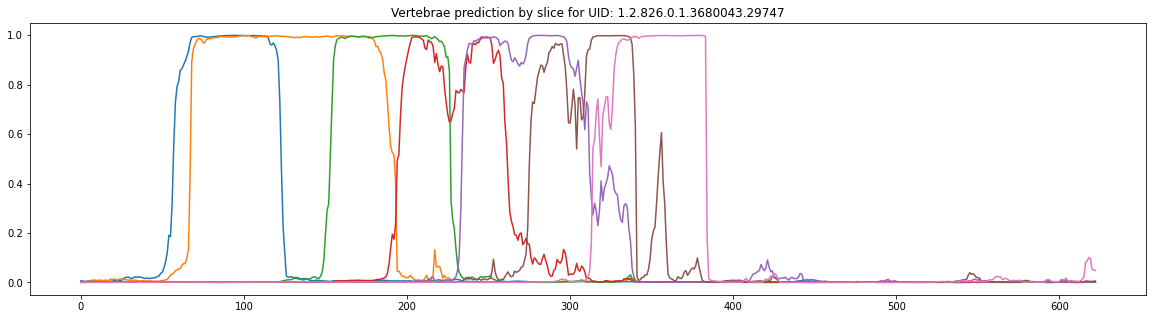

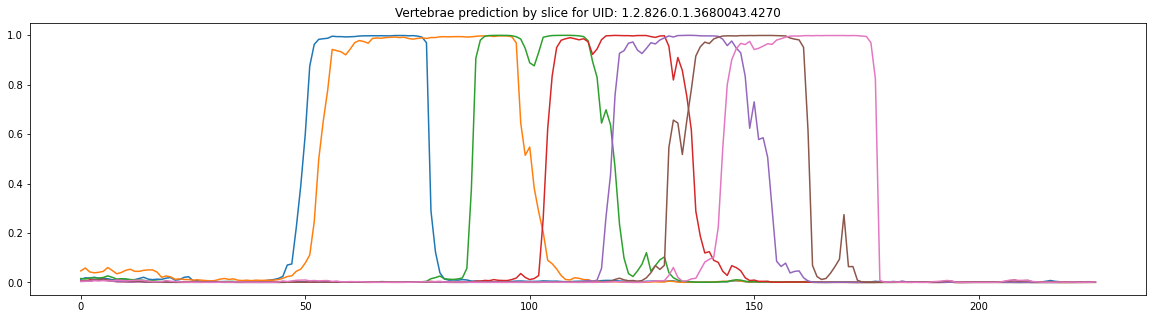

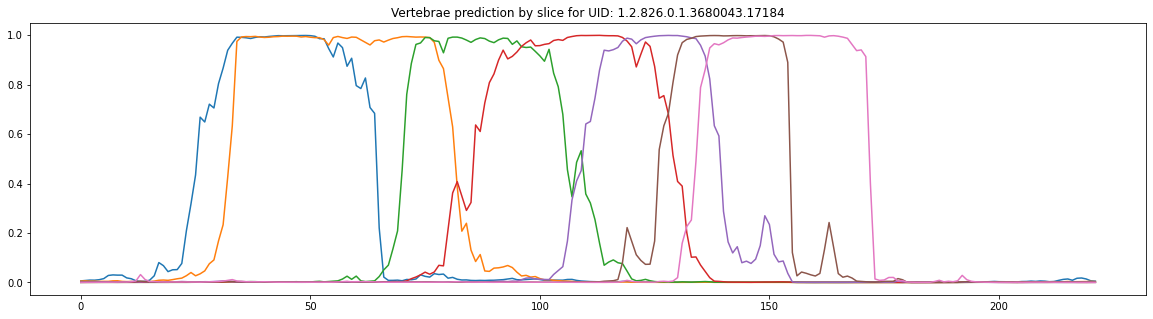

In [ ]:
for uid in np.random.choice(df_train.StudyInstanceUID, 3):
    pred = predict_vertebrae(df_train.query('StudyInstanceUID == @uid'), seg_models[:2])
    plt.figure(figsize=(20, 5))
    plt.plot(pred)
    plt.title(f'Vertebrae prediction by slice for UID: {uid}')

In [ ]:
pred = predict_vertebrae(df_train, seg_models[:N_MODELS_FOR_INFERENCE])

Eval:   0%|          | 0/22238 [00:00<?, ?it/s]

In [ ]:
df_train[[f'C{i}' for i in range(1, 8)]] = pred
df_train.to_csv('train_segmented.csv', index=False)